# Train NN model on the FashionMNIST data

https://www.kaggle.com/zalando-research/fashionmnist

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

You may refer to this tutorial about the original Mnist:
https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

Or any other tutorial you may find online:
https://www.kaggle.com/zalando-research/fashionmnist/code

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torch.optim as optim
import matplotlib.pyplot as plt

from typing import List, Callable, Tuple
%matplotlib inline

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
training_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

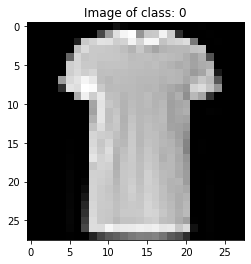

In [10]:
# Lest read a random image from the dataset and draw it
image, label = training_data[17]
plt.imshow(image[0], "gray")
plt.title(f"Image of class: {label}")
plt.show()

In [6]:
# Lets check image shape
image.shape

torch.Size([1, 28, 28])

In [7]:
# Lets see all the classes available
training_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

# Task 1:

Create a DataLoader objects for train and test

In [11]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [235]:
# next(iter(train_dataloader))

In [236]:
# next(iter(test_dataloader))

In [12]:
device

device(type='cuda', index=0)

# Task 2:

Create a Neural Network

In [13]:
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.flatten(x)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = F.relu(x)

        x = self.fc4(x)
        output = F.log_softmax(x, dim=1)

        return output


net = Net()
net.to(device)

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

# Task 3:

Specify loss and optimizer

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

epochs = 10
train_losses, train_accuracy = [], []

In [15]:
print(len(training_data))

60000


# Task 3:

Train model using for loop

In [16]:
def train_model(model: nn.Module,
                epochs: int,
                dataloader: DataLoader = train_dataloader,
                criter: Callable[[torch.Tensor, torch.Tensor], float] = nn.CrossEntropyLoss(),
                optim: torch.optim.Optimizer = optim.Adam(net.parameters(), lr=0.001)) -> None:

    for i in range(epochs):
        epoch_loss = 0
        correct_epoch = 0
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            optim.zero_grad()

            output = model.forward(X)
            _, preds = torch.max(output, dim=1)

            loss = criter(output, y)

            loss.backward()
            optim.step()

            epoch_loss += loss.item()

            correct_epoch += (preds == y).float().sum()


        acc = correct_epoch / len(training_data)
        epoch_loss = epoch_loss / len(train_dataloader)
        train_accuracy.append(acc.cpu().detach().numpy())
        train_losses.append(epoch_loss)
        print("Epoch: {}/{}..".format(i+1, epochs),
          "Training loss: {:.3f}..".format(epoch_loss),
          "Training Accuracy: {:.3f}".format(acc))


    fig = plt.figure(figsize=(10, 10))
    plt.plot(train_losses, label="train loss")
    plt.plot(train_accuracy, label="train accuracy")
    plt.legend(frameon = False)


def predict(img: torch.Tensor,
            model: nn.Module) -> str:
    prediction = model.forward(img)
    _, cls = torch.max(prediction, dim=1)

    return training_data.classes[cls]


def test_model(model: nn.Module,
               dataloader: DataLoader = test_dataloader) -> (torch.Tensor, torch.Tensor):

        predictions = torch.Tensor([]).to(device)
        true_labels = torch.Tensor([]).to(device)

        with torch.no_grad():
            for X, y in dataloader:
                X, y = X.to(device), y.to(device)
                preds = model.forward(X)
                predictions = torch.cat((predictions, preds), 0)
                true_labels = torch.cat((true_labels, y), 0)

        _, correct = torch.max(predictions, dim=1)
        accuracy =  (correct == true_labels).float().sum() / len(true_labels)
        print("Test accuracy: {:.3f}".format(accuracy))

        return correct, true_labels


Epoch: 1/10.. Training loss: 0.536.. Training Accuracy: 0.804
Epoch: 2/10.. Training loss: 0.377.. Training Accuracy: 0.862
Epoch: 3/10.. Training loss: 0.337.. Training Accuracy: 0.876
Epoch: 4/10.. Training loss: 0.313.. Training Accuracy: 0.884
Epoch: 5/10.. Training loss: 0.297.. Training Accuracy: 0.890
Epoch: 6/10.. Training loss: 0.280.. Training Accuracy: 0.896
Epoch: 7/10.. Training loss: 0.265.. Training Accuracy: 0.902
Epoch: 8/10.. Training loss: 0.253.. Training Accuracy: 0.905
Epoch: 9/10.. Training loss: 0.246.. Training Accuracy: 0.907
Epoch: 10/10.. Training loss: 0.235.. Training Accuracy: 0.911


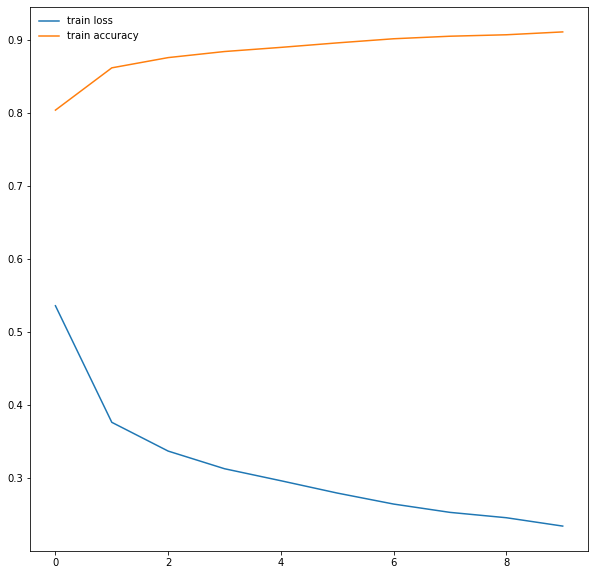

In [17]:
train_model(net, epochs, train_dataloader, criterion, optimizer)

# Task 4:

Report accuracy from train set, and test set independently

In [18]:
preds, labels = test_model(net, test_dataloader)

Test accuracy: 0.888


# Task 5:

Report confussion matrix for the test set

Expected format:
```
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
```

In [19]:
from sklearn.metrics import confusion_matrix
import numpy as np
print("Confusion Matrix: \n")

try:
    preds = np.apply_along_axis(float, axis=1, arr=preds.cpu().detach().numpy().reshape(-1, 1))
    labels = labels.cpu().detach().numpy()
except AttributeError:
    pass

confusion = confusion_matrix(labels, preds)
print(confusion)

Confusion Matrix: 

[[833   1  11  11   6   0 131   0   7   0]
 [  2 974   1  17   3   0   2   0   1   0]
 [ 13   0 816  10  69   0  91   0   1   0]
 [ 23   9  17 862  51   0  34   0   4   0]
 [  1   0 113  19 802   0  64   0   1   0]
 [  0   0   0   1   0 962   0  20   0  17]
 [102   2  70  18  56   0 741   0  11   0]
 [  0   0   0   0   0  18   0 967   0  15]
 [  4   0   2   1   2   2   8   1 980   0]
 [  0   0   0   0   0   9   1  47   0 943]]


### TESTING MODEL ON FEW IMAGES FROM TEST SET

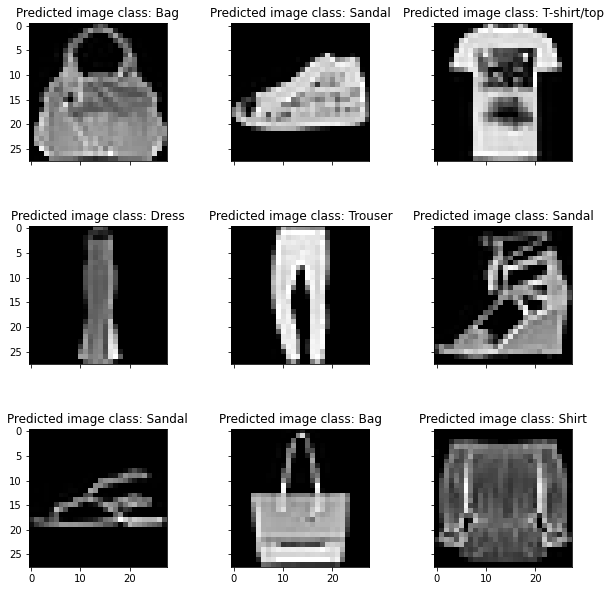

In [21]:
def predict_k_photos(model: nn.Module,
                        size: int,
                        data: torch.Tensor) -> None:
    from mpl_toolkits.axes_grid1 import ImageGrid

    fig = plt.figure(figsize=(10, 10))
    grid = ImageGrid(fig, 111,
                 nrows_ncols=(size, size),
                 axes_pad=0.9,
                 )
    indexes = np.random.randint(0, len(data), size * size)
    images = [data[i] for i in indexes]
    for ax, im in zip(grid, images):
        ax.imshow(im[0][0], "gray")
        ax.set_title("Predicted image class: {}".format(predict(im[0].to(device), model)))


predict_k_photos(net, 3, test_data)

### SAVING MODEL

In [24]:
torch.save(net, "models/fashionMNISTmodel.pt")

### LOADING MODEL

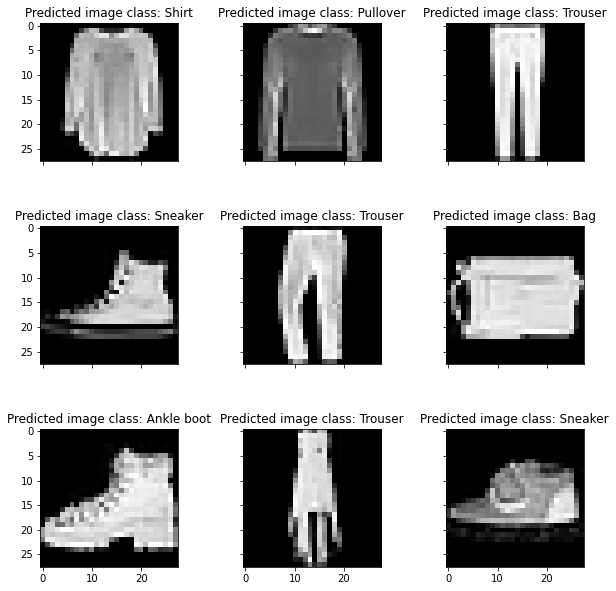

In [28]:
model = torch.load("models/fashionMNISTmodel.pt")
model.eval()

predict_k_photos(model, 3, test_data)

# Task 6 (optional):

Train LogisticRegression and DecisionTree models on the same data
Compare their performance to the NN